<a href="https://colab.research.google.com/github/KayalvizhiT513/ID3-algorithm/blob/main/Decision_Tree_algorithm.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from graphviz import Digraph
import matplotlib.pyplot as plt
import math

In [14]:
class TreeNode:
    def __init__(self, label=None, attribute=None, branches=None):
        self.label = label
        self.attribute = attribute
        self.branches = branches or {}

    def get_label(self):
        if self.label is not None:
            return self.label
        elif self.attribute is not None:
            return self.attribute
        else:
            return ""

    def is_leaf(self):
        return not bool(self.branches)

    def add_to_dot(self, dot):
        node_id = str(id(self))
        label = self.get_label()

        if self.is_leaf():
            # Set shape to rectangle for leaf nodes
            dot.node(node_id, label=label, shape='rectangle')
        else:
            dot.node(node_id, label=label)

        for branch_label, branch in self.branches.items():
            branch.add_to_dot(dot)
            dot.edge(node_id, str(id(branch)), label=branch_label)


In [3]:
def id3(examples, target_attribute, attributes):
    # Create a root node for the tree
    root = TreeNode()

    # If all examples are positive, return a single-node tree with label = '+'
    if all(example[target_attribute] == 'yes' for example in examples):
        root.label = 'yes'
    # If all examples are negative, return a single-node tree with label = '-'
    elif all(example[target_attribute] == 'no' for example in examples):
        root.label = 'no'
    # If attributes is empty, return a single-node tree with label = most common value of Targetattribute
    elif not attributes:
        root.label = most_common_value(examples, target_attribute)
    else:
        # Choose the best attribute to split on
        best_attribute = choose_best_attribute(examples, target_attribute, attributes)
        root.attribute = best_attribute

        # Split the examples based on the chosen attribute
        attribute_values = set(example[best_attribute] for example in examples)

        for value in attribute_values:
            subset = [example for example in examples if example[best_attribute] == value]

            if not subset:
                # If subset is empty, add a leaf node with label = most common value of Targetattribute
                leaf = TreeNode(label=most_common_value(examples, target_attribute))
                root.branches[value] = leaf
                print("Leaf: ", leaf)
            else:
                # Recursively add subtree
                subtree = id3(subset, target_attribute, [attr for attr in attributes if attr != best_attribute])
                root.branches[value] = subtree

    return root

In [4]:
def most_common_value(examples, target_attribute):
    # Return the most common value of the target attribute in the given examples
    positive_count = sum(1 for example in examples if example[target_attribute] == 'yes')
    negative_count = sum(1 for example in examples if example[target_attribute] == 'no')
    return 'yes' if positive_count >= negative_count else 'no'


In [5]:
def calculate_entropy(examples, target_attribute):
    # Calculate the entropy of a set of examples based on the target attribute
    total_count = len(examples)
    positive_count = sum(1 for example in examples if example[target_attribute] == 'yes')
    negative_count = total_count - positive_count

    if positive_count == 0 or negative_count == 0:
        return 0  # Entropy is 0 if all examples are of the same class

    positive_prob = positive_count / total_count
    negative_prob = negative_count / total_count

    entropy = - (positive_prob * math.log2(positive_prob) + negative_prob * math.log2(negative_prob))

    return entropy

def calculate_information_gain(examples, target_attribute, attribute):
    # Calculate the Information Gain for a specific attribute
    total_entropy = calculate_entropy(examples, target_attribute)

    attribute_values = set(example[attribute] for example in examples)
    weighted_entropy = 0

    for value in attribute_values:
        subset = [example for example in examples if example[attribute] == value]
        subset_entropy = calculate_entropy(subset, target_attribute)
        subset_weight = len(subset) / len(examples)
        weighted_entropy += subset_weight * subset_entropy

    information_gain = total_entropy - weighted_entropy
    return information_gain

def choose_best_attribute(examples, target_attribute, attributes):
    # Choose the attribute with the highest Information Gain
    best_attribute = None
    max_information_gain = -1

    for attribute in attributes:
        information_gain = calculate_information_gain(examples, target_attribute, attribute)
        if information_gain > max_information_gain:
            max_information_gain = information_gain
            best_attribute = attribute

    return best_attribute


In [6]:
def print_tree(node, indent=0):
    if node.label is not None:
        print("  " * indent + f"Label: {node.label}")
    else:
        print("  " * indent + f"Attribute: {node.attribute}")
        for value, subtree in node.branches.items():
            print("  " * (indent + 1) + f"Value: {value}")
            print_tree(subtree, indent + 2)


In [10]:
# Example usage
examples = [
    {'A': 'Sunny', 'B': 'Hot', 'PlayTennis': 'yes'},
    {'A': 'Sunny', 'B': 'Cool', 'PlayTennis': 'yes'},
    {'A': 'Overcast', 'B': 'Hot', 'PlayTennis': 'yes'},
    {'A': 'Rain', 'B': 'Mild', 'PlayTennis': 'no'},
    {'A': 'Rain', 'B': 'Cool', 'PlayTennis': 'no'},
    {'A': 'Overcast', 'B': 'Mild', 'PlayTennis': 'yes'},
]

Attribute: A
  Value: Rain
    Label: no
  Value: Sunny
    Label: yes
  Value: Overcast
    Label: yes


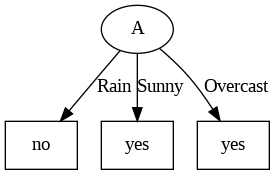

In [15]:
attributes = ['A', 'B']
target_attribute = 'PlayTennis'

tree = id3(examples, target_attribute, attributes)
print_tree(tree)

# Create a Digraph object
dot = Digraph(comment='Tree')

# Add nodes and edges to the Digraph
tree.add_to_dot(dot)

# Render the tree in Colab
dot.render(filename='tree', format='png', cleanup=True, engine='dot')

# Display the tree image in Colab
from IPython.display import Image
Image(filename='tree.png')

Attribute: Outlook
  Value: Rain
    Attribute: Wind
      Value: Strong
        Label: no
      Value: Weak
        Label: yes
  Value: Sunny
    Attribute: Humidity
      Value: High
        Label: no
      Value: Normal
        Label: yes
  Value: Overcast
    Label: yes


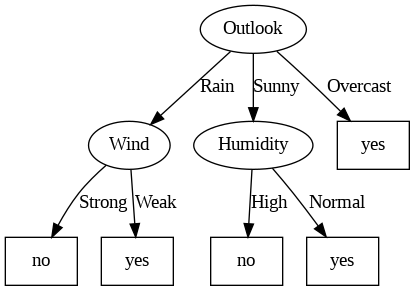

In [16]:
import pandas as pd

# Load data from Excel file
file_path = '/content/training_example.xlsx'
df = pd.read_excel(file_path)

# Drop the first column
df = df.drop(df.columns[0], axis=1)

# Example attributes and target_attribute
attributes = df.columns[:-1].tolist()
target_attribute = df.columns[-1]

# Example usage
tree = id3(df.to_dict(orient='records'), target_attribute, attributes)
print_tree(tree)

# Create a Digraph object
dot = Digraph(comment='Tree')

# Add nodes and edges to the Digraph
tree.add_to_dot(dot)

# Render the tree in Colab
dot.render(filename='tree1', format='png', cleanup=True, engine='dot')

# Display the tree image in Colab
from IPython.display import Image
Image(filename='tree1.png')

Attribute: Patrons
  Value: Full
    Attribute: Hungry
      Value: Yes
        Attribute: Type
          Value: Thai
            Attribute: Fri/Sat
              Value: Yes
                Label: yes
              Value: No
                Label: no
          Value: Burger
            Label: yes
          Value: Italian
            Label: no
      Value: No
        Label: no
  Value: Some
    Label: yes
  Value: None
    Label: no


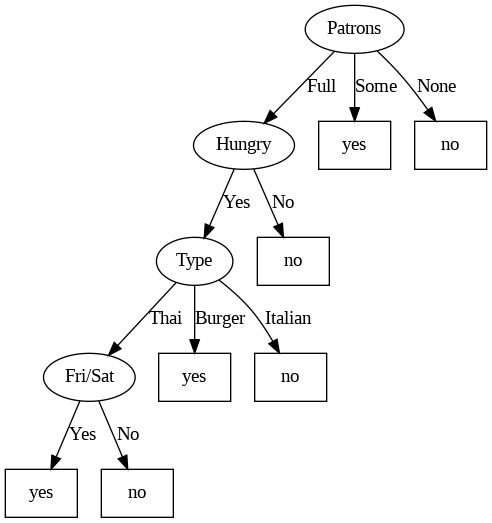

In [17]:
import pandas as pd

# Load data from Excel file
file_path = '/content/restaurant.xlsx'
df = pd.read_excel(file_path)

# Drop the first column
df = df.drop(df.columns[0], axis=1)

# Example attributes and target_attribute
attributes = df.columns[:-1].tolist()
target_attribute = df.columns[-1]

# Example usage
tree = id3(df.to_dict(orient='records'), target_attribute, attributes)
print_tree(tree)

# Create a Digraph object
dot = Digraph(comment='Tree')

# Add nodes and edges to the Digraph
tree.add_to_dot(dot)

# Render the tree in Colab
dot.render(filename='tree3', format='png', cleanup=True, engine='dot')

# Display the tree image in Colab
from IPython.display import Image
Image(filename='tree3.png')